In [15]:
import pet
import models
from visualizer import Plotter
import composition

import warnings
from scipy.integrate import simpson
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime as dt

import ipywidgets as widgets
from IPython.display import display

#%matplotlib nbagg
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")
#mammal = pet.Ruminant(**pet.animals['bos_taurus_alentejana'])
mammal = pet.Ruminant(**pet.animals['bos_taurus_angus'])
#mammal = pet.Ruminant(**pet.animals['bos_taurus_limousin'])
#mammal = pet.Ruminant(**pet.animals['bos_taurus_charolais'])
print(mammal)
# print(mammal.check_viability())

Parameters at T=311.75 K
Surface-specific maximum assimilation rate: 20590.3 (J/d.cm^2)
Allocation fraction to soma: 0.937766541 (-)
Energy conductance: 0.271867 (cm/d)
Volume-specific somatic maintenance rate: 519.603 (J/d.cm^3)
Specific cost for structure: 8844.512631 (J/cm^3)
Maturity maintenance rate constant: 0.00101893 (d^-1)
Maturity at birth: 7863765.193 (J)
Maturity at puberty: 54638121.69 (J)
Reproduction efficiency: 0.95 (-)

Chemical Reactions:
Assimilation: 3.492 X + 1.124 O2 -> E + 1.366 CO2 + 0.4115 H2O + 0.1583 CO(NH2)2 + 0.5856 CH4 + 0.3819 P
Dissipation: E + 1.087 O2 -> 0.925 CO2 + 0.75 H2O + 0.075 CO(NH2)2
Growth: E + 0.1254 O2 ->  0.8846 V + 0.1067 CO2 + 0.08652 H2O + 0.008652 CO(NH2)2



In [3]:
def compute_metrics(breed, p_Am, kap_X, v):
    mammal = pet.Ruminant(**pet.animals[f'bos_taurus_{breed.lower()}'])
    mammal._p_Am = p_Am
    mammal.kap_X = kap_X
    mammal._v = v
    model = models.RUM(mammal)
    sol = model.simulate(food_function=1, t_span=(0, 440), step_size='auto', initial_state='birth')

    for i, t in enumerate(sol.t):
        if t > 330:
            t1 = sol[t]
            t1_i = i
            break
    t2 = sol.time_instant_sols[-1]
    tfi = -simpson(sol.organic_fluxes[0, t1_i:], sol.t[t1_i:]) * sol.time_instant_sols[-1].organism.comp.X.w
    td = (t2.t - t1.t)
    dfi = tfi / td
    adg = (t2.wet_weight - t1.wet_weight) / td
    fcr = dfi / adg
    rgr = (np.log(t2.wet_weight) - np.log(t1.wet_weight)) / td
    # dfi =
    print(f"DFI: {dfi:.5} g\n"
          f"ADG: {adg:.4} g\n"
          f"FCR: {fcr:.4}\n"
          f"RGR: {rgr * 100:.4} %")
    
def default_values(event):
    # print(event)
    if event['name'] == 'label':
        breed = event['new']
        p_Am_widget.value = pet.animals[f'bos_taurus_{breed.lower()}']['p_Am']
        v_widget.value = pet.animals[f'bos_taurus_{breed.lower()}']['v']

In [4]:
cow_selector = widgets.Dropdown(options=['Alentejana', 'Angus', 'Charolais', 'Limousin'], value='Alentejana', description='Breed:', disabled=False)
p_Am_widget = widgets.FloatSlider(min=1000, max=8000, value=mammal._p_Am, description='$\{\dot{p}_{Am}\}$')
kap_X_widget = widgets.FloatSlider(min=0, max=1, value=mammal.kap_X, description='$\kappa_X$', step=0.05)
v_widget = widgets.FloatSlider(min=0.01, max=1, value=mammal._v, description='$\dot{v}$', step=0.01)
cow_selector.observe(default_values)

# display(p_Am_widget, kap_X_widget, cow_selector)
widgets.interactive(compute_metrics, breed=cow_selector, p_Am=p_Am_widget, kap_X=kap_X_widget, v=v_widget)

interactive(children=(Dropdown(description='Breed:', options=('Alentejana', 'Angus', 'Charolais', 'Limousin'),…

In [5]:
angus = pd.read_csv("../Data/Angus/angus_2020_processed.csv")
duration = 105
angus.head()

,Name,SIA,DataNasc,2020-08-19,2020-09-09,2020-09-30,2020-10-21,2020-11-11,2020-12-02,Inges MB,...,GC,AOB,DFI,ADG,FCR,RGR,age,E[DFI],RFI,weight_gain
0,ALICERCE MR SMITH ONE L44,PT223654406,2019-09-24,353,385,437,487,526,560,1975.7,...,7.875,68,10.942124,1.971429,5.550353,0.439494,435,12.003390,-1.061267,207.0
1,ZAMBUJAL RED LÍBANO L5725,PT923343435,2019-09-30,382,415,466,500,543,572,2011.0,...,8.940,78,11.136029,1.809524,6.154121,0.384494,429,9.766958,1.369070,190.0
2,AGRIANGUS LUIGI L9523,PT123649523,2019-10-05,540,572,632,660,712,726,2673.8,...,16.090,77,14.859524,1.771429,8.388441,0.281887,424,14.077047,0.782476,186.0
3,PV LEGISLADOR L3743,PT223973743,2019-10-18,332,368,413,442,478,524,1643.8,...,5.820,74,9.113676,1.828571,4.984042,0.434625,411,11.502719,-2.389042,192.0
4,SOBRAL LATIGO L7373,PT623627373,2019-10-21,363,386,427,460,489,524,1777.0,...,10.270,73,9.848724,1.533333,6.423081,0.349608,408,10.357088,-0.508365,161.0


In [6]:
final_ages = [float(t) for t in angus['age'].values]
initial_ages = [t-105 for t in final_ages]
print(initial_ages, final_ages)

[330.0, 324.0, 319.0, 306.0, 303.0, 297.0, 295.0, 293.0, 289.0, 288.0, 259.0, 239.0] [435.0, 429.0, 424.0, 411.0, 408.0, 402.0, 400.0, 398.0, 394.0, 393.0, 364.0, 344.0]


In [7]:
mammal = pet.Ruminant(**pet.animals['bos_taurus_angus'])
def compare_deb_with_data(p_Am, v, p_M, kap_X, kappa):
    fig, axes = plt.subplots(1,2,figsize=(16,10))
    sns.scatterplot(data=angus, x='age', y='weight_gain', ax=axes[0])
    sns.scatterplot(data=angus, x='age', y='Inges MS', ax=axes[1])
    weight_gains_list = []
    feed_consumption_list = []
    format_strings = ['yo-', 'ro-']
    for i in range(2):
        mammal = pet.Ruminant(**pet.animals['bos_taurus_angus'])
        mammal._p_Am = p_Am[i]
        mammal._v = v[i]
        mammal._p_M = p_M[i]
        mammal.kap_X = kap_X[i]
        mammal.kappa = kappa[i]

        # Simulate Angus cow with DEB
        model = models.RUM(mammal)
        sol = model.simulate(food_function=1, t_span=(0, 450), step_size='auto', initial_state='birth')
        
        # Compute weight gains during experiment duration, assuming initial test for each data point
        weight_gains_deb = []
        for agei, agef in zip(initial_ages, final_ages):
            weight_gains_deb.append((sol[agef].wet_weight - sol[agei].wet_weight) / 1000)
        weight_gains_list.append(weight_gains_deb)
        axes[0].plot(final_ages, weight_gains_deb, format_strings[i])
        
        # Compute feed consumption
        feed_cons_deb = []
        for agei, agef in zip(initial_ages, final_ages):
            feed_cons_deb.append(sol.total_feed_intake(t1=sol.find_closest_time_step(agei),t2=sol.find_closest_time_step(agef))/1000)
        feed_consumption_list.append(feed_cons_deb)
        axes[1].plot(final_ages, feed_cons_deb, format_strings[i])
        
    # Weight plot
    axes[0].fill_between(final_ages, weight_gains_list[0], weight_gains_list[1], alpha=0.5, zorder=-1)
    axes[0].set_ylabel('Weight Gain during Test [kg]', fontsize=16)
    axes[0].set_xlabel('Age at end of Test [d]', fontsize=16)
    axes[0].grid()
    axes[0].set_xlim([340, 440])
    axes[0].set_ylim([0, 300])
    
    # Feed Consumption Plot
    axes[1].fill_between(final_ages, feed_consumption_list[0], feed_consumption_list[1], alpha=0.5, zorder=-1)
    axes[1].set_ylabel('Feed Consumption during Test [kg]', fontsize=16)
    axes[1].set_xlabel('Age at end of Test [d]', fontsize=16)
    axes[1].grid()
    axes[1].set_xlim([340, 440])
    axes[1].set_ylim([0, 1750])
    

# WIDGETS
p_Am_widget = widgets.FloatRangeSlider(min=1000, max=10000, value=(mammal._p_Am, mammal._p_Am), description='$\{\dot{p}_{Am}\}$', layout=widgets.Layout(width='40%'))
v_widget = widgets.FloatRangeSlider(min=0.01, max=0.25, value=(mammal._v, mammal._v), description='$\dot{v}$', step=0.001, layout=widgets.Layout(width='40%'))
p_M_widget = widgets.FloatRangeSlider(min=50, max=250, value=(mammal._p_M, mammal._p_M), description='$[\dot{p}_M]$', layout=widgets.Layout(width='40%'))
kap_X_widget = widgets.FloatRangeSlider(min=0, max=1, value=(mammal.kap_X, mammal.kap_X), description='$\kappa_X$', layout=widgets.Layout(width='40%'), step=0.01)
kappa_widget = widgets.FloatRangeSlider(min=0, max=1, value=(mammal.kappa, mammal.kappa), description='$\kappa$', layout=widgets.Layout(width='40%'), step=0.01)

widgets.interactive(compare_deb_with_data, p_Am=p_Am_widget, v=v_widget, p_M=p_M_widget, kap_X=kap_X_widget, kappa=kappa_widget)

interactive(children=(FloatRangeSlider(value=(4041.526574, 4041.526574), description='$\\{\\dot{p}_{Am}\\}$', …

In [8]:
#mammal = pet.Ruminant(**pet.animals['bos_taurus_alentejana'])
mammal = pet.Pet(**pet.animals['sheep'])
feed_weight = pd.read_csv("../Data/ACBM/CSV Files/weight_intake_2021.csv")
feed_weight

,id,date,cumul_feed,cumul_dry,weight,age
0,14,2021-07-28,8.6,5.34060,321,292
1,15,2021-07-28,10.2,6.33420,264,314
2,16,2021-07-28,9.3,5.77530,365,335
3,18,2021-07-28,13.5,8.38350,311,326
4,19,2021-07-28,11.2,6.95520,318,352
...,...,...,...,...,...,...
196,40,2021-11-25,1052.7,657.34000,332,416
197,41,2021-11-25,1248.1,779.66830,388,409
198,42,2021-11-25,1426.8,891.25710,446,457
199,43,2021-11-25,1311.2,819.38124,404,411


In [ ]:

def cbrt(num):
    return np.power(num, 1/3)
f = 1
#mammal.kap_X = 0.999
alpha = mammal.p_Am * mammal.comp.X.w / mammal.comp.X.mu / mammal.kap_X * f
omega = 1 + f * mammal.E_m * mammal.comp.E.w / mammal.comp.E.d / mammal.comp.E.mu 
r_b = mammal.von_bertanlanffy_growth_rate(f)
Li = mammal.L_m*f
model = models.STD(mammal)
Lb = cbrt(model.get_state_at_maturity(mammal.E_Hb)[1])
Wi = cbrt(omega)*Li
Wb = cbrt(omega)*Lb

def tfi_vs_time(t):
    return alpha * (-0.5 / r_b * ((2*Li - (Li - Lb) * np.exp(-r_b*t))**2 - (Li + Lb)**2) + Li * Li * t)
def tfi_vs_length(L):
    return alpha / r_b * (-0.5  * ( (Li + L)**2 - (Li + Lb)**2 ) + Li * Li * np.log((Li-Lb)/(Li-L)))
def tfi_vs_weight(w):
    W = cbrt(w)
    return alpha * ((1/omega)**(2/3)) / r_b * (-0.5  * ( (Wi + W)**2 - (Wi + Wb)**2 ) + Wi * Wi * np.log((Wi-Wb)/(Wi-W)))

sol = model.simulate(food_function=f, t_span=(0, 4500), step_size='auto', initial_state='birth')

from scipy.integrate import cumulative_trapezoid

In [ ]:
print(tfi_vs_weight(10_000) / 1.034)
print(tfi_vs_weight(13_000) / 1.034)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
t = np.linspace(0, 4500, 4500)
ax.plot(t, tfi_vs_time(t), label='Analytical', linewidth=3)

tfi = cumulative_trapezoid(-sol.feed_intake, sol.t, initial=0)
ax.plot(sol.t, tfi, '-.', label='Simulation', alpha=0.7, linewidth=3)

ax.grid()
ax.set_xlabel("Time [d]", fontsize=16)
ax.set_ylabel("Total Feed Intake [g]", fontsize=16)
ax.set_title("Total Feed Intake vs Time", fontsize=16)
ax.legend()
fig.savefig("Figures/tfi_time")

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
L = np.linspace(Lb, Li, len(sol.t))
ax.plot(L, tfi_vs_length(L), label='Analytical', linewidth=3)

simul_lengths = cbrt(sol.V)
print(simul_lengths)
tfi = cumulative_trapezoid(-sol.feed_intake, initial=0)

ax.plot(simul_lengths, tfi, '-.', label='Simulation', alpha=0.7, linewidth=3)
ax.grid()
ax.set_xlabel("Length [cm]", fontsize=16)
ax.set_ylabel("Total Feed Intake [g]", fontsize=16)
ax.set_title("Total Feed Intake vs Length", fontsize=16)
ax.legend()
fig.savefig("Figures/tfi_length")

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
W = np.linspace(Wb**3, Wi**3, len(sol.t))
ax.plot(W, tfi_vs_weight(W), label='Analytical', linewidth=3)


tfi = cumulative_trapezoid(-sol.feed_intake, initial=0)

ax.plot(sol.wet_weight, tfi, '-.', label='Simulation', alpha=0.7, linewidth=3)
ax.grid()
ax.set_xlabel("Wet Weight [g]", fontsize=16)
ax.set_ylabel("Total Feed Intake [g]", fontsize=16)
ax.set_title("Total Feed Intake vs Length", fontsize=16)
ax.legend()
fig.savefig("Figures/tfi_weight")

In [68]:
mammal = pet.Ruminant(**pet.animals['ovis_aries_lacaune'])
mammal._p_Am = 32* 57.54/.955
model = models.RUM(mammal)
sol = model.simulate(food_function=0.7, t_span=(0, 33), step_size='auto', initial_state='birth')


C:\Users\diogo\OneDrive\Documentos\Terraprima\Code\DEB-Python\models.py:233: RuntimeWarning: invalid value encountered in double_scalars
  return E * (self.organism.E_G * self.organism.v * (V ** (-1 / 3)) + self.organism.p_M) / \
C:\Users\diogo\OneDrive\Documentos\Terraprima\Code\DEB-Python\models.py:243: RuntimeWarning: invalid value encountered in double_scalars
  return self.organism.p_M * V + self.organism.p_T * (V ** (2 / 3))
C:\Users\diogo\OneDrive\Documentos\Terraprima\Code\DEB-Python\models.py:525: RuntimeWarning: invalid value encountered in double_scalars
  return self.organism.E_G * self.organism.v * (V ** (2 / 3))
C:\Users\diogo\OneDrive\Documentos\Terraprima\Code\DEB-Python\models.py:431: RuntimeWarning: invalid value encountered in double_scalars
  dE = self.organism.v * self.organism.E_density_mother * (V ** (2 / 3))


In [72]:
mammal._p_Am

1928.041884816754

In [39]:
df = pd.read_csv("../Data/Sheep 4.0/lamb_weights_2022.csv")
df['dob'] = df['dob'].astype(str)
df.head()


,id,dob,wb,2022-02-18,2022-02-28,2022-03-07
0,654,2022-02-03,3.8,NaN,NaN,NaN
1,655,2022-02-03,3.8,0.0,8.0,8.8
2,656,2022-02-03,3.8,0.0,6.0,7.0
3,657,2022-02-03,4.8,7.8,9.6,11.2
4,658,2022-02-03,4.8,0.0,9.6,0.0


In [43]:
np.isnan(df.loc[0,'2022-02-18'])

True

In [46]:
dates = ['2022-02-18', '2022-02-28', '2022-03-07']
weights_dict = {'id': [], 'age':[], 'weight': []}
for i in df.index.values:
    lamb_dob = dt.fromisoformat(df.loc[i,'dob'])
    lamb_id = df.loc[i,'id']
    weights_dict['id'].append(lamb_id)
    weights_dict['weight'].append(df.loc[i,'wb'])
    weights_dict['age'].append(0)
    for d in dates:
        d_dt = dt.fromisoformat(d)
        lamb_weight = df.loc[i,d]
        if lamb_weight == 0 or np.isnan(lamb_weight):
            continue
        weights_dict['id'].append(lamb_id)
        weights_dict['weight'].append(lamb_weight)
        weights_dict['age'].append((d_dt-lamb_dob).days)
lamb = pd.DataFrame(weights_dict)
lamb.head()

,id,age,weight
0,654,0,3.8
1,655,0,3.8
2,655,25,8.0
3,655,32,8.8
4,656,0,3.8


In [52]:
avg_w = lamb.groupby(by='age').mean().weight
avg_w

age
0      4.494444
12     7.533333
13     7.000000
14     6.800000
15     7.900000
22     8.371429
23     8.657143
24     8.700000
25     9.230000
29     9.342857
30    10.333333
31    10.225000
32    11.150000
Name: weight, dtype: float64

Text(0.5, 1.0, 'Evolução dos Pesos dos Borregos Nascidos em 2022')

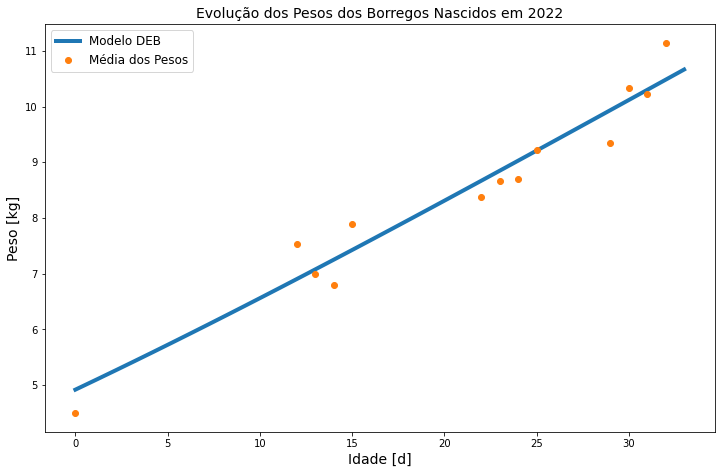

In [69]:
fig, ax = plt.subplots(figsize=(12,7.5))
ax.plot(sol.t, sol.wet_weight / 1000, label='Modelo DEB', linewidth=4)
ax.set_ylabel("Peso [kg]",fontsize=14)
ax.set_xlabel("Idade [d]",fontsize=14)

ax.plot(avg_w, 'o', label='Média dos Pesos')
ax.legend(fontsize=12)
ax.set_title("Evolução dos Pesos dos Borregos Nascidos em 2022", fontsize=14)